# Car damage Copilot with GPT-4 Turbo Vision

<img src="screenshot.jpg">

**GPT-4 Turbo with Vision** is a large multimodal model (LMM) developed by OpenAI that can analyze images and provide textual responses to questions about them. It incorporates both natural language processing and visual understanding. This guide provides details on the capabilities and limitations of GPT-4 Turbo with Vision.

**Enhancements** let you incorporate other Azure AI services (such as Azure AI Vision) to add new functionality to the chat-with-vision experience.

- **Object grounding**: Azure AI Vision complements GPT-4 Turbo with Vision’s text response by identifying and locating salient objects in the input images. This lets the chat model give more accurate and detailed responses about the contents of the image.

- **Optical Character Recognition (OCR)**: Azure AI Vision complements GPT-4 Turbo with Vision by providing high-quality OCR results as supplementary information to the chat model. It allows the model to produce higher quality responses for images with dense text, transformed images, and numbers-heavy financial documents, and increases the variety of languages the model can recognize in text.

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/gpt-with-vision

In [1]:
import base64
import datetime
import glob
import gradio as gr
import json
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [3]:
check_openai_version()

Installed OpenAI version: 1.12.0
[OK] OpenAI version 1.12.0 is >= 1.0.0


In [4]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 26-Feb-2024 15:34:12


In [6]:
print(f"Python version: {sys.version}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]


## 1. Azure AI services

In [7]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.12.0


In [8]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")

# 2. Azure AI Vision
AZURE_AI_VISION_KEY = os.getenv("AZURE_AI_VISION_KEY")
AZURE_AI_VISION_ENDPOINT = os.getenv("AZURE_AI_VISION_ENDPOINT")

In [9]:
model = "gpt-4TurboVision"  # This is the deployed name of your GPT4 Vision model from the Azure Open AI studio

## 2. Functions

In [10]:
def local_image_to_data_url(image_path):
    """
    Local image => url
    """
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [11]:
def analyse_image(image_file, prompt):
    """
    Analyse an image using GPT-4 Turbo with Vision
    """
    base_url = f"{openai.api_base}/openai/deployments/{model}"
    headers = {
        "Content-Type": "application/json",
        "api-key": openai.api_key,
    }

    img = local_image_to_data_url(image_file)

    # Prepare endpoint, headers, and request body
    endpoint = f"{base_url}/extensions/chat/completions?api-version=2023-12-01-preview"
    data = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"ocr": {"enabled": True}, "grounding": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVision",
                "parameters": {
                    "endpoint": AZURE_AI_VISION_ENDPOINT,
                    "key": AZURE_AI_VISION_KEY,
                },
            }
        ],
        "messages": [
            {
                "role": "system",
                "content": "You are an auto insurance report. Analyse this image.",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"{img}",
                        },
                    },
                ],
            },
        ],
        "max_tokens": 4000,
        "temperature": 0,
    }

    # Make the API call
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        results = json.loads(response.text)
        print("\033[1;31;34m")
        print("[Answer]", results["choices"][0]["message"]["content"])
        print("\033[1;31;32m")
        print(
            "[Note] These results are produced by an AI and should be verified by a professional."
        )
        print(
            datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"),
            "Powered by Azure OpenAI GPT-4 Turbo with vision model",
        )
        print("\033[0m")

        return results

    elif response.status_code == 429:
        print("\033[1;31;91m")
        print(
            "[429 Error] Too many requests. Please wait a couple of seconds and try again.\n"
        )
        print(json.loads(response.text))
        print("\033[0m")

    else:
        print(f"[Error] Error code: {response.status_code}\n")
        print(json.loads(response.text))

In [12]:
client = AzureOpenAI(
    api_key=openai.api_key,
    api_version="2023-12-01-preview",
    base_url=f"{openai.api_base}/openai/deployments/{model}/extensions",
)

In [13]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 3. Examples

### Example 1

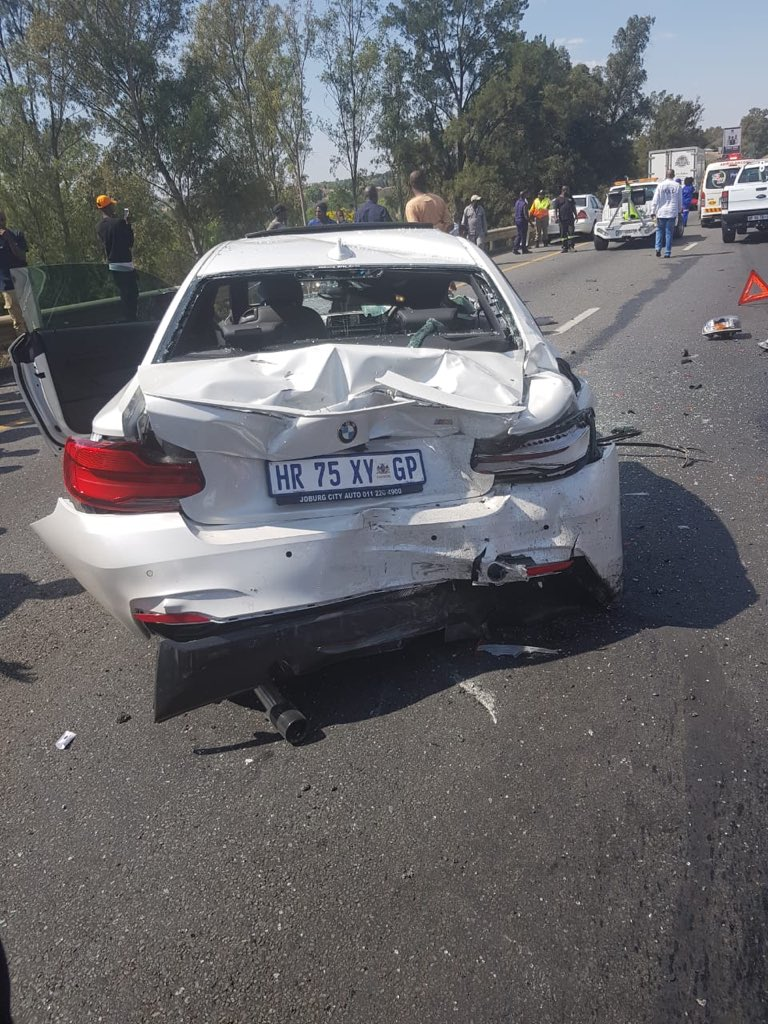

In [14]:
image_file = "images/car1.jpg"

img = Image.open(image_file)
img

In [15]:
prompt = "What is the brand and model of this vehicle?"

analyse_image(image_file, prompt)


[Answer] The vehicle in the image is a BMW, as indicated by the distinctive roundel logo with blue and white quadrants, which is visible on the trunk of the car. The specific model of the BMW is not clearly visible due to the angle and the damage to the vehicle. However, based on the design features that are visible, such as the shape of the rear lights and the overall size, it appears to be a sedan from the 3 or 5 Series, which are common models with such design features. The exact model would require a clearer view or additional information to determine.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 15:34:18 Powered by Azure OpenAI GPT-4 Turbo with vision model

Time elapsed in seconds = 5.92884


{'id': 'chatcmpl-8wXHbFWcWK01zY1WysWucmHP4bKUW',
 'object': 'chat.completion',
 'created': 1708961655,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The vehicle in the image is a BMW, as indicated by the distinctive roundel logo with blue and white quadrants, which is visible on the trunk of the car. The specific model of the BMW is not clearly visible due to the angle and the damage to the vehicle. However, based on the design features that are visible, such as the shape of the rear lights and the overall size, it appears to be a sedan from the 3 or 5 Series, which are common models with such design features. The 

In [17]:
prompt = "What is the licence plate number of this vehicle? Print only the answer"

analyse_image(image_file, prompt)


[Answer] HR 75 XY GP

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:50:27 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRusPhBn9xlLGyr5EQGWQUngDY1c',
 'object': 'chat.completion',
 'created': 1708941026,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'HR 75 XY GP'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'HR 75 XY GP',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 915, 'completion_tokens': 5, 'total_tokens': 920}}

In [18]:
prompt = "What is the color of the vehicle? Print only the answer"

analyse_image(image_file, prompt)


[Answer] White

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:50:30 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRuvjZroI4v01cvtydtJ8WHRqGq4',
 'object': 'chat.completion',
 'created': 1708941029,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'White'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'White', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 913, 'completion_tokens': 1, 'total_tokens': 914}}

In [19]:
prompt = "Classify this vehicle into 'Motorbike', 'SUV', 'Sedan', 'Truck', 'Convertible'. Print only the answer"

analyse_image(image_file, prompt)


[Answer] Sedan

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:50:32 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRuyKH2LLoyPUCi3Y3jhhn3oHFCh',
 'object': 'chat.completion',
 'created': 1708941032,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'Sedan'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'Sedan', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 930, 'completion_tokens': 3, 'total_tokens': 933}}

In [20]:
prompt = "Do we have any damage with this vehicle?"

analyse_image(image_file, prompt)


[Answer] 

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:50:41 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRv0kejir9jhRzFIPnWHMX18kus8',
 'object': 'chat.completion',
 'created': 1708941034,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'content_filter',
   'index': 0,
   'message': {'role': 'assistant', 'content': ''},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': True, 'severity': 'medium'}},
   'enhancements': {'grounding': {'lines': [{'text': '', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 910,
  'completion_tokens': 248,
  'total_tokens': 1158}}

### Example 2

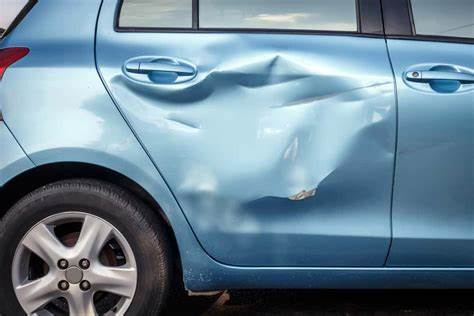

In [21]:
image_file = "images/car2.jpg"

img = Image.open(image_file)
img

In [23]:
prompt = "Do we have a damage in this vehicle? Just say YES or NO"

analyse_image(image_file, prompt)


[Answer] YES

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:51:13 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRvddganCnV0brENv3CzsSe9ktr6',
 'object': 'chat.completion',
 'created': 1708941073,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'YES'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'YES', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 323, 'completion_tokens': 1, 'total_tokens': 324}}

In [25]:
prompt = "Do we have a damage in this vehicle? Explain the details of the damage."

analyse_image(image_file, prompt)


[Answer] Yes, there is damage to the vehicle. The image shows a blue car with significant denting on the rear passenger door. The dent appears to be quite deep, affecting both the upper and lower panels of the door. There is also visible paint damage, with the paint being scraped off at the point of deepest indentation near the lower part of the door. The deformation of the door panel suggests a strong lateral impact, which may have compromised the structural integrity of the door. The door handle area, however, seems to be intact with no visible damage. The damage will likely require professional bodywork to repair the dents and a paint job to restore the vehicle's appearance.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:51:30 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRvqznIxB1FLugxWaazPm9BgCxza',
 'object': 'chat.completion',
 'created': 1708941086,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': "Yes, there is damage to the vehicle. The image shows a blue car with significant denting on the rear passenger door. The dent appears to be quite deep, affecting both the upper and lower panels of the door. There is also visible paint damage, with the paint being scraped off at the point of deepest indentation near the lower part of the door. The deformation of the door panel suggests a strong lateral impact, which may have compromised the structural integrity of the d

In [26]:
prompt = "Where is located the damage?"

analyse_image(image_file, prompt)


[Answer] The damage is located on the rear passenger side door of the vehicle. There is a significant dent with multiple creases and a visible tear in the metal near the bottom of the door. The door's shape is distorted due to the impact, which may affect its ability to open and close properly. The paint is also damaged around the dented area.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:51:38 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRvzga39JeIRXObLGgZFun797AUZ',
 'object': 'chat.completion',
 'created': 1708941095,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': "The damage is located on the rear passenger side door of the vehicle. There is a significant dent with multiple creases and a visible tear in the metal near the bottom of the door. The door's shape is distorted due to the impact, which may affect its ability to open and close properly. The paint is also damaged around the dented area."},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe

In [27]:
prompt = "Classify the location of the damage into 'FRONT', 'REAR' or 'SIDE'. Print only the answer."

analyse_image(image_file, prompt)


[Answer] SIDE

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:51:56 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRwKS31A2PveE0U5DburnF66dftg',
 'object': 'chat.completion',
 'created': 1708941116,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'SIDE'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'SIDE', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 333, 'completion_tokens': 1, 'total_tokens': 334}}

### Example 3

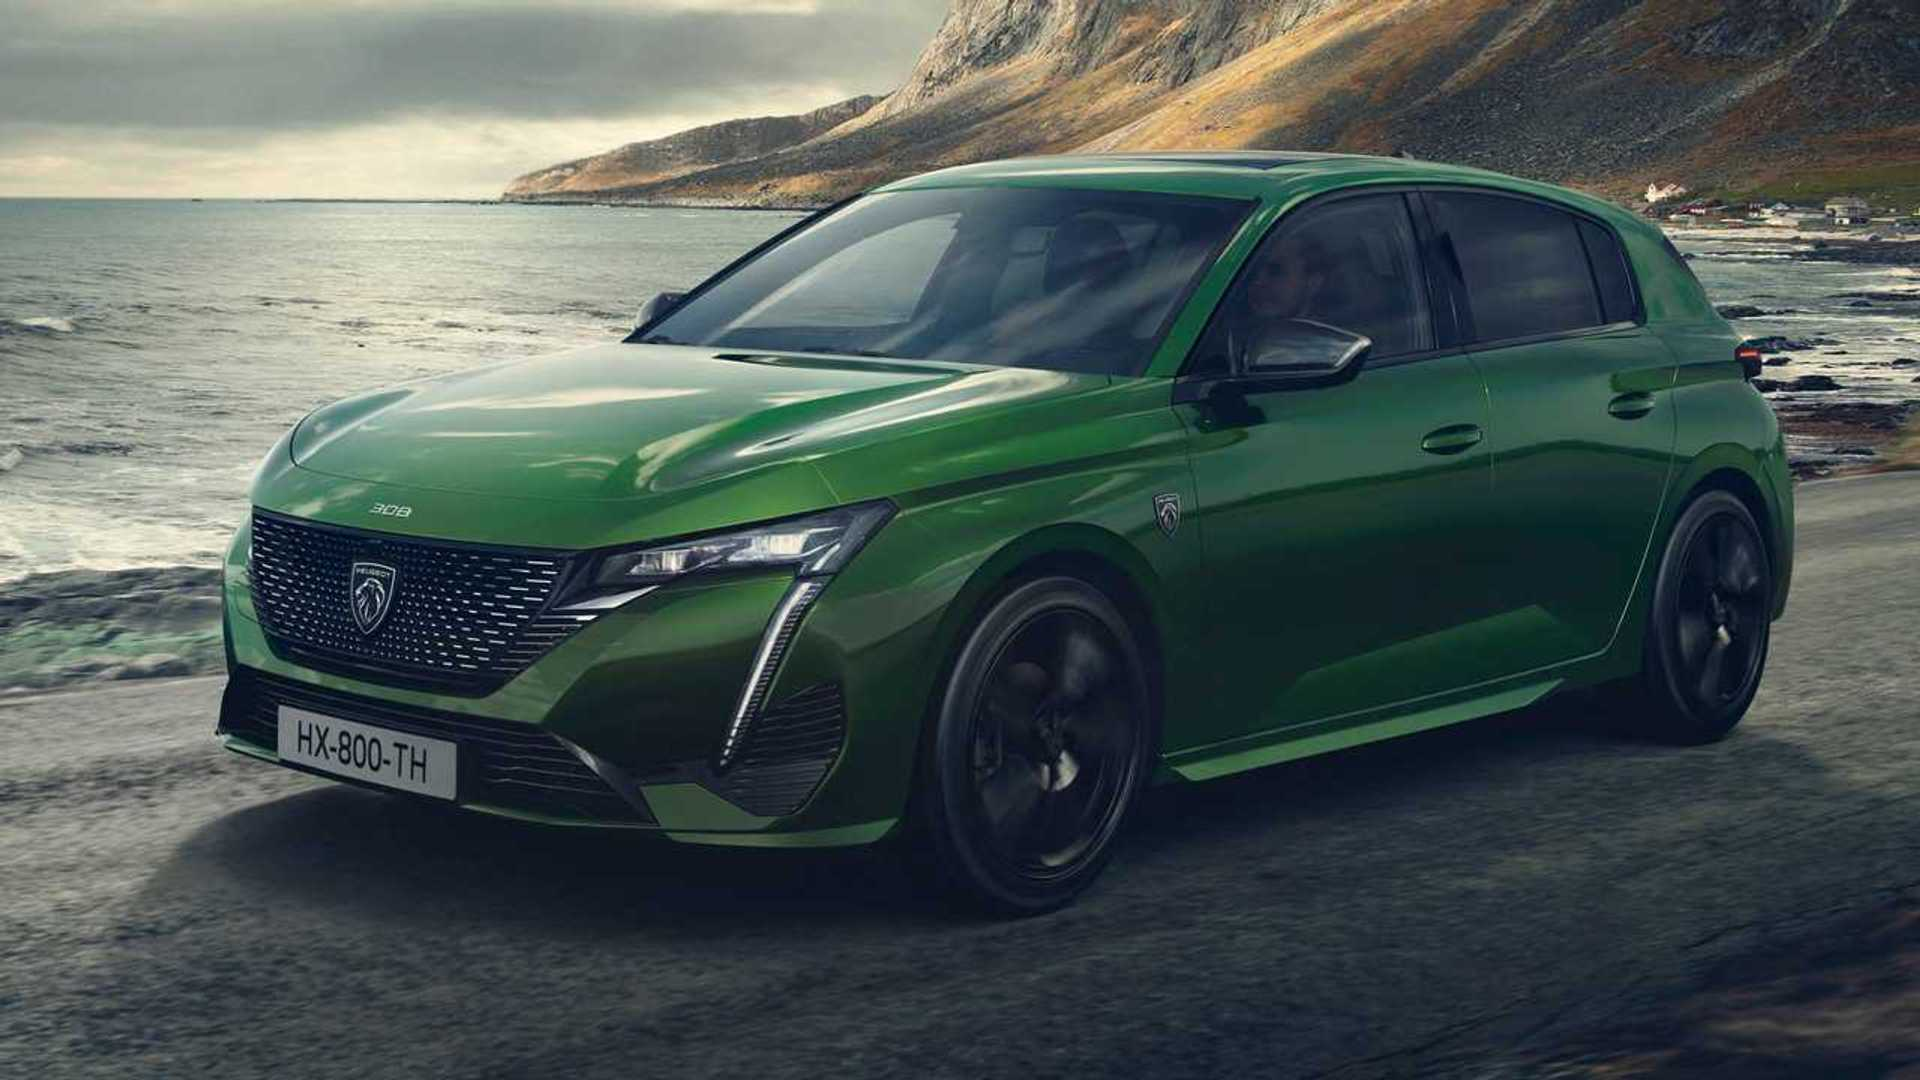

In [28]:
image_file = "images/car3.jpg"

img = Image.open(image_file)
img

In [29]:
prompt = "What is the brand and model of this vehicle? Just print the answer."

analyse_image(image_file, prompt)


[Answer] The brand and model of the vehicle is a Peugeot 308.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:52:11 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRwYfAhaJOHE3v6HJKG8zRjuRigq',
 'object': 'chat.completion',
 'created': 1708941130,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The brand and model of the vehicle is a Peugeot 308.'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'The brand and model of the vehicle is a Peugeot 308.',
       'spans': []}],
     'status': 'Success'}}}],
 'usag

In [30]:
prompt = "What can you tell about this car model? Just print the answer."

analyse_image(image_file, prompt)


[Answer] The car in the image is a Peugeot 308, as indicated by the badge on the front grille and the model number on the side of the vehicle. It features a distinctive front grille design with the Peugeot emblem in the center, sharp and angular LED headlights, and a sporty overall aesthetic. The vehicle is painted in a vibrant green color, which is not a common color for cars, suggesting it might be a special edition or a custom option. The license plate reads "HX-800-TH," which could indicate the vehicle's registration information. The car is depicted in motion on a coastal road, which adds to its dynamic and adventurous image.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:52:20 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRweahfb2n5CA78OU4JnjtCAQhRY',
 'object': 'chat.completion',
 'created': 1708941136,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The car in the image is a Peugeot 308, as indicated by the badge on the front grille and the model number on the side of the vehicle. It features a distinctive front grille design with the Peugeot emblem in the center, sharp and angular LED headlights, and a sporty overall aesthetic. The vehicle is painted in a vibrant green color, which is not a common color for cars, suggesting it might be a special edition or a custom option. The license plate reads "HX-800-TH," whi

In [31]:
prompt = "What is the color of this vehicle? Just print the answer."

analyse_image(image_file, prompt)


[Answer] Green

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:52:28 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRwpFpViD1khLKOgHmVHxx7W1fKy',
 'object': 'chat.completion',
 'created': 1708941147,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'Green'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'Green', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1273,
  'completion_tokens': 1,
  'total_tokens': 1274}}

In [33]:
prompt = "What is in the background? Print only the answer."

analyse_image(image_file, prompt)


[Answer] A rocky coastline with a rough sea and a cloudy sky.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:52:40 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRx0yEUodLpayYF8m6CXO9GEavVX',
 'object': 'chat.completion',
 'created': 1708941158,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'A rocky coastline with a rough sea and a cloudy sky.'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'A rocky coastline with a rough sea and a cloudy sky.',
       'spans': []}],
     'status': 'Success'}}}],
 'usag

In [37]:
prompt = "What is the licence plate number of this vehicle? Print only the answer."

analyse_image(image_file, prompt)


[Answer] HX-800-TH

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:53:03 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRxP2IvYhKIBBOWhUTuTprNrzitR',
 'object': 'chat.completion',
 'created': 1708941183,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'HX-800-TH'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'HX-800-TH',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1275,
  'completion_tokens': 5,
  'total_tokens': 1280}}

In [38]:
prompt = "Do we have a damage in this vehicle? Just answer 'YES' or 'NO'"

analyse_image(image_file, prompt)


[429 Error] Too many requests. Please wait a couple of seconds and try again.

{'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create_WithExtensions Operation under Azure OpenAI API version 2023-12-01-preview have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 4 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}



### Example 4

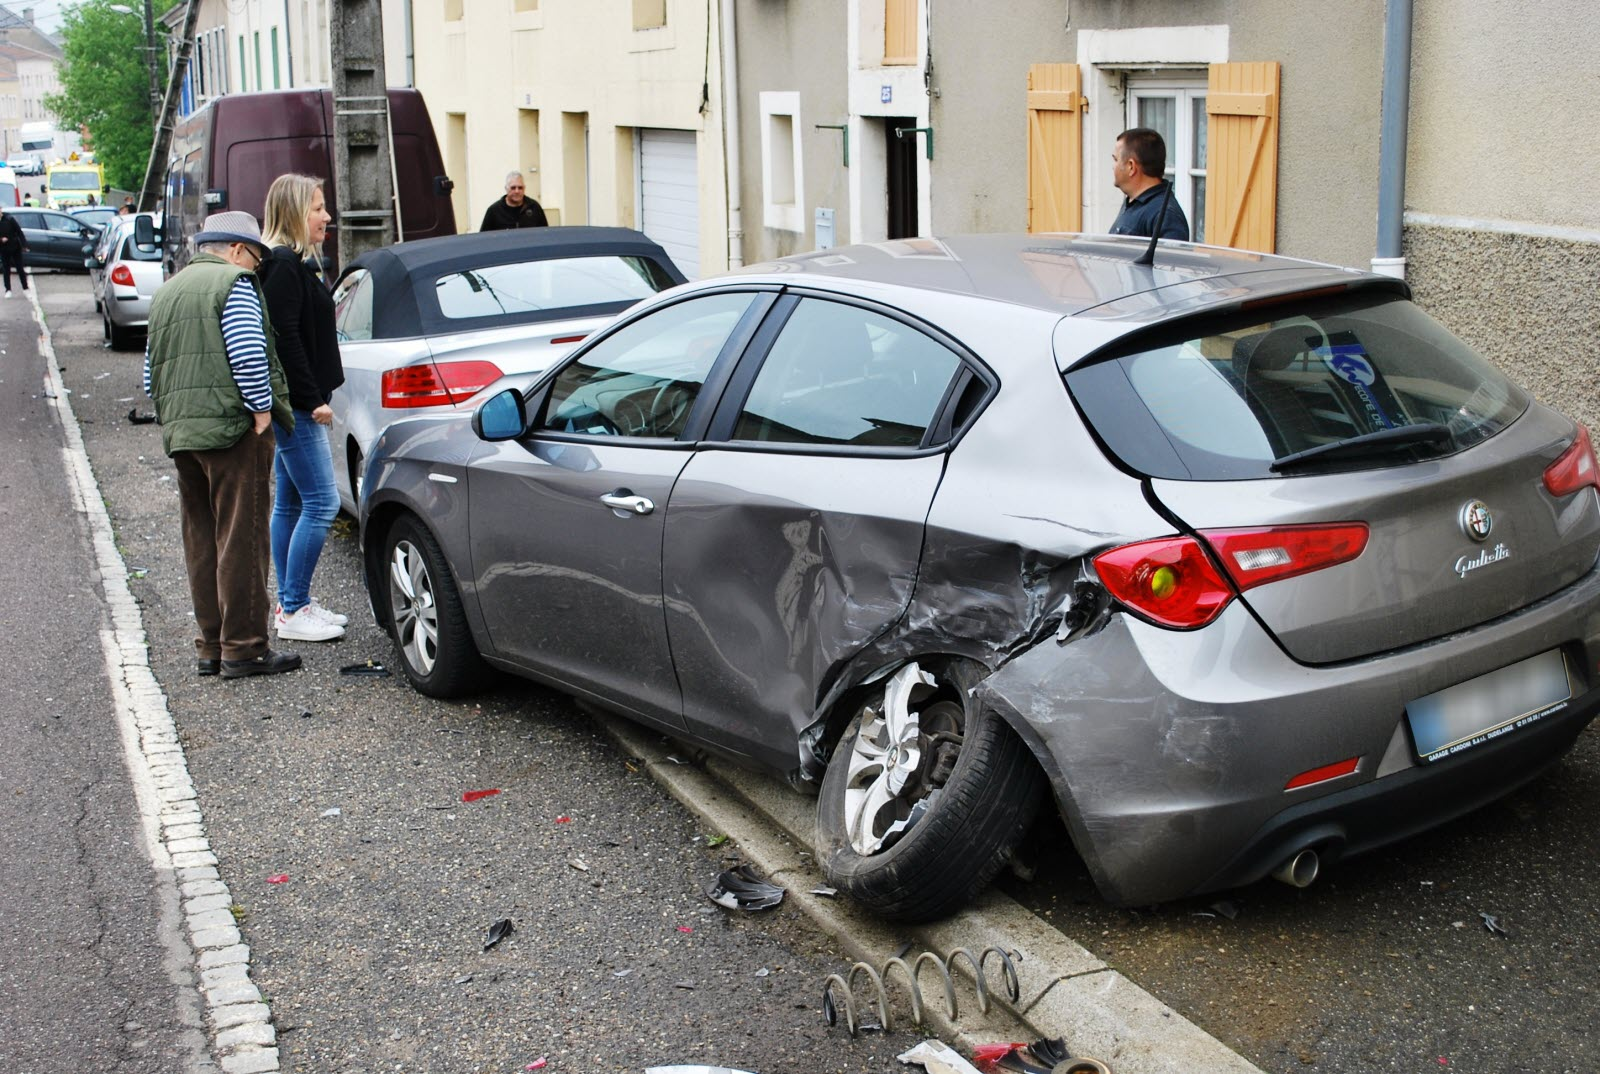

In [39]:
image_file = "images/car4.jpg"

img = Image.open(image_file)
img

In [40]:
prompt = "Generate a caption for this image"

analyse_image(image_file, prompt)


[Answer] The image shows a silver-colored car with significant damage to its rear right side, indicating it has been involved in a collision. The rear bumper is partially detached, and the bodywork around the wheel arch and rear passenger door is crumpled, with visible scratches and dents. The rear wheel is also damaged and the tire appears to be flat, suggesting a forceful impact. Debris from the car is scattered on the road, including pieces of the light and bumper. There are two individuals standing near the car, possibly assessing the damage. Another car is parked in front of the damaged vehicle, and a van is visible further down the street. The environment suggests an urban setting with residential buildings. The license plate of the damaged car is not clearly visible. There is no visible damage to the front of the car or any other cars in the immediate vicinity, which may indicate that this vehicle was struck from the side or rear rather than being involved in a head-on collisio

{'id': 'chatcmpl-8wRxZ4j4S7rV73VDEvTjDImVb8oz4',
 'object': 'chat.completion',
 'created': 1708941193,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The image shows a silver-colored car with significant damage to its rear right side, indicating it has been involved in a collision. The rear bumper is partially detached, and the bodywork around the wheel arch and rear passenger door is crumpled, with visible scratches and dents. The rear wheel is also damaged and the tire appears to be flat, suggesting a forceful impact. Debris from the car is scattered on the road, including pieces of the light and bumper. There are

In [41]:
prompt = "What is the brand and model of this vehicle? Print only the brand followed by the model."

analyse_image(image_file, prompt)


[Answer] Alfa Romeo Giulietta

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:53:31 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRxqGSUPYdqZ2QuG26TjDKSsIHOA',
 'object': 'chat.completion',
 'created': 1708941210,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'Alfa Romeo Giulietta'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'Alfa Romeo Giulietta',
       'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1274,
  'completion_tokens': 6,
  'total_token

In [42]:
prompt = "What is the color of the car? Print only the answer."

analyse_image(image_file, prompt)


[Answer] Grey

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:53:37 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRxwH74IGuuhm2a7wJ4ZtvZ2XsDR',
 'object': 'chat.completion',
 'created': 1708941216,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'Grey'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'Grey', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1268,
  'completion_tokens': 1,
  'total_tokens': 1269}}

In [43]:
prompt = "Do we have a damage in this vehicle? Just answer 'YES' or 'NO'"

analyse_image(image_file, prompt)


[Answer] YES

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:53:44 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRy431cnSvKuG2YI32P7qxIkY39i',
 'object': 'chat.completion',
 'created': 1708941224,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'YES'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'YES', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1274,
  'completion_tokens': 1,
  'total_tokens': 1275}}

In [45]:
prompt = "Do we have a damage in this vehicle? Share some details about the damages."

analyse_image(image_file, prompt)


[Answer] The vehicle in the image, an Alfa Romeo Giulietta, has sustained significant damage to its rear right side. The rear bumper is severely dented and partially detached, with visible scratches and paint damage. The right rear wheel appears to be damaged as well, with the tire potentially punctured or deflated, and the rim may be bent or broken. The rear right passenger door and quarter panel are also heavily dented, which could indicate damage to the vehicle's frame or suspension. There is debris on the ground, including pieces of the car's bodywork and other materials, which suggests a recent collision. The damage is extensive enough that it may affect the vehicle's drivability and structural integrity, requiring professional repair.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:54:13 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRyPagXYkgtGOGMFh68Qdc68cMns',
 'object': 'chat.completion',
 'created': 1708941245,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': "The vehicle in the image, an Alfa Romeo Giulietta, has sustained significant damage to its rear right side. The rear bumper is severely dented and partially detached, with visible scratches and paint damage. The right rear wheel appears to be damaged as well, with the tire potentially punctured or deflated, and the rim may be bent or broken. The rear right passenger door and quarter panel are also heavily dented, which could indicate damage to the vehicle's frame or su

In [46]:
prompt = "Classify the location of the damage into 'FRONT', 'REAR' or 'SIDE'. Print only the classification answer."

analyse_image(image_file, prompt)


[Answer] SIDE

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:54:22 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRyf6dMOVwtk85BwXpjhlqSQi7K6',
 'object': 'chat.completion',
 'created': 1708941261,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'SIDE'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'SIDE', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1281,
  'completion_tokens': 1,
  'total_tokens': 1282}}

## Exemple 5

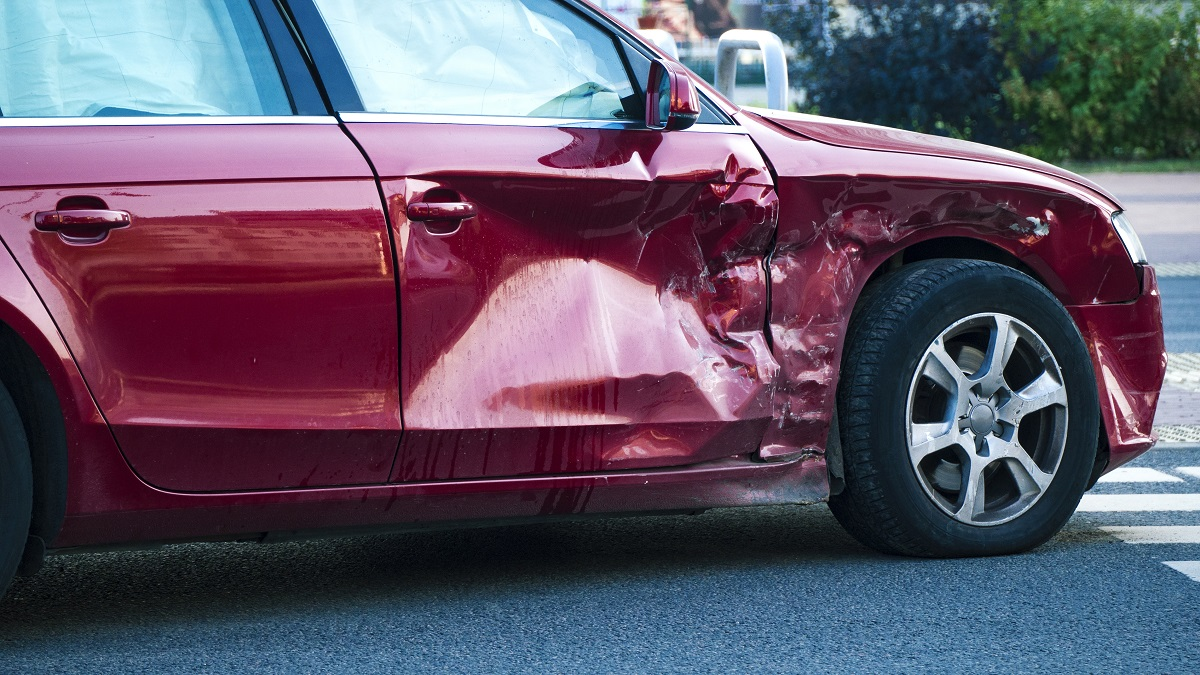

In [47]:
image_file = "images/car5.jpg"

img = Image.open(image_file)
img

In [48]:
prompt = "Describe this"

analyse_image(image_file, prompt)


[Answer] The image shows a red car with significant damage to the rear passenger side. The rear door and quarter panel are severely dented and crumpled, indicating a forceful side-impact collision. The paint is scraped off in several areas, and there are visible creases and distortions in the metal, suggesting that the car was hit with considerable force. The rear wheel appears intact but may have sustained damage that is not visible from this angle. The damage is likely to impede the opening of the rear passenger door and could have compromised the structural integrity of the vehicle. An assessment by a professional would be necessary to determine the full extent of the damage and whether the car is repairable or a total loss.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:54:42 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRywRmz87O7VJQq98ZqEOuGWHqkW',
 'object': 'chat.completion',
 'created': 1708941278,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The image shows a red car with significant damage to the rear passenger side. The rear door and quarter panel are severely dented and crumpled, indicating a forceful side-impact collision. The paint is scraped off in several areas, and there are visible creases and distortions in the metal, suggesting that the car was hit with considerable force. The rear wheel appears intact but may have sustained damage that is not visible from this angle. The damage is likely to imp

In [49]:
prompt = "What is the color of the car? Print only the answer."

analyse_image(image_file, prompt)


[Answer] Red

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:54:49 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRz7SVE2jy1AGsgMAZRr5l4MsDYh',
 'object': 'chat.completion',
 'created': 1708941289,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'Red'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'Red', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1141,
  'completion_tokens': 1,
  'total_tokens': 1142}}

In [50]:
prompt = "Do we have a damage in this vehicle? Just answer 'YES' or 'NO'"

analyse_image(image_file, prompt)


[Answer] YES

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:54:55 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRzCtwD3l5Ms4CUFVkwrhZVWTJ4S',
 'object': 'chat.completion',
 'created': 1708941294,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant', 'content': 'YES'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'enhancements': {'grounding': {'lines': [{'text': 'YES', 'spans': []}],
     'status': 'Success'}}}],
 'usage': {'prompt_tokens': 1146,
  'completion_tokens': 1,
  'total_tokens': 1147}}

In [52]:
prompt = "What is the damage on this vehicle? Print only the answer."

analyse_image(image_file, prompt)


[Answer] The vehicle has significant side damage to the rear passenger door and rear quarter panel, including dents, paint damage, and potential structural damage. The rear wheel also appears to be damaged and may affect the alignment and suspension.

[Note] These results are produced by an AI and should be verified by a professional.
26-Feb-2024 09:55:11 Powered by Azure OpenAI GPT-4 Turbo with vision model



{'id': 'chatcmpl-8wRzRNrLaHordssy45kG3UFJbawnD',
 'object': 'chat.completion',
 'created': 1708941309,
 'model': 'gpt-4',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}}}],
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'The vehicle has significant side damage to the rear passenger door and rear quarter panel, including dents, paint damage, and potential structural damage. The rear wheel also appears to be damaged and may affect the alignment and suspension.'},
   'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 

## 4. Gradio webapp

In [53]:
def car_damage_copilot_fn(pil_image):
    """
    Car damage with GPT-4 Turbo Vision
    """

    prompt = """
    Analyze this car damage image for an auto insurance report, focusing on identifying and detailing damage.
    Always reply in English.
    You respond with your analysis of the following fields:

    1. Summary: Create a summary of this damage.

    2. Brand/model: What is the brand and model of this vehicle?

    3. Color: What is the color of the vehicle?

    4. Licence plate: What is the licence plate number of the vehicle?

    5. Damage: Do we have a damage in this vehicle?

    6. Damage information and location: What is the damage and its location?

    7. Damage location: Can you detect the location of the damage using of these 3 values 'FRONT', 'SIDE' or 'REAR'?
 
    8. Confidence level: What is the confidence level of this damage classification?

    9. Hashtags and emojis: Generate some hashtags and emojis to describe this image
    
    """
    # Save the PIL image to a BytesIO object
    byte_arr = BytesIO()
    pil_image.save(byte_arr, format="JPEG")
    byte_data = byte_arr.getvalue()
    base64_encoded_data = base64.b64encode(byte_data).decode("utf-8")
    mime_type = "image/jpeg"
    img = f"data:{mime_type};base64,{base64_encoded_data}"

    # Calling Azure OpenAI model
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": f"{img}",
                    },
                ],
            },
        ],
        max_tokens=4000,
        temperature=0,
    )

    return response.choices[0].message.content

In [55]:
# Logo
image_url = "https://github.com/retkowsky/images/blob/master/cardamagelogo.png?raw=true"
logo = "<center> <img src= {} width=70px></center>".format(image_url)

# Title
title = "Your car damage Copilot (Azure Open AI GPT-4 Turbo Vision)"

# Get list of all jpg files as samples
examples = glob.glob("images/*.jpg")

# Theme
theme = "gradio/soft"
# List of themes: https://huggingface.co/spaces/gradio/theme-gallery

# Inputs & outputs components
inputs = gr.Image(type="pil", label="Your image")
outputs = gr.Text(label="Car damage analysis")

# Webapp
car_damage_copilot_webapp = gr.Interface(
    fn=car_damage_copilot_fn,
    inputs=inputs,
    outputs=outputs,
    description=logo,
    title=title,
    examples=examples,
    theme=theme,
)

# Let's start the webapp
car_damage_copilot_webapp.launch(share=True)

themes/theme_schema@0.0.3.json: 100%|██████████| 13.1k/13.1k [00:00<00:00, 20.9MB/s]


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://4d7f43b3093d0177ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
